# Reproduce results in paper

This is the code used to achieve to results in our [paper]().

All the imports are grouped together here.

In [54]:
# Standard Library
import os, sys
import glob, shutil

# PyPI dependencies
import imageio
import tqdm

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn import preprocessing

# Confirm we are working in the correct directory.
path = '/home/atom/emotion/' # change this to the correct path
if os.getcwd().split(os.sep)[-1] != 'emotion':
    os.chdir(path)
assert os.getcwd().split(os.sep)[-1] == 'emotion', 'please set the correct path. Current: {0}'.format(os.getcwd())

# import JVAER tools
from JVAER import utils
from JVAER import scrape_tools

In [55]:
#あとで消そう
import JVAER
import importlib

importlib.reload(JVAER.utils)
importlib.reload(JVAER.scrape_tools)
importlib.reload(JVAER.logger)
;

''

## Scrape Data

In [56]:
# Choose paths to save data
out_dir_path = 'datasets/XperFace'

# Set up save directories
dirs1 = ['images', 'videos', 'embeddings', 'cropped_images', 'inliers', 'outliers']
for querylist_path in glob.glob('./notebooks/querylists/*.txt'): 
    lang, _ = os.path.splitext(os.path.basename(querylist_path))

    # Read namelist
    queries = JVAER.utils.read_querylist(querylist_path)
    dirs2 = [os.path.join(lang, query) for query in queries]

    JVAER.utils.make_save_dirs(out_dir_path, dirs1, dirs2, overwrite=True)
    
queries = [os.path.basename(g) for g in glob.glob('./datasets/XperFace/*/*/*')]

### scrape images for each query

In [ ]:
n_images = 50 # Number of images of each person to scrape
chromedriver_path = 'JVAER/chromedriver' # path to chromedriver

for query in queries:
    # get_face_images frequently fails to get n_images, it will usually get more than 80%
    # if there are 0 images found it will recurse and try again.
    JVAER.scrape_tools.get_face_images(query, n_images, os.path.join(out_dir_path, 'images'), chromedriver_path)

[2020-01-03 02:21:17,428] WARNING @ line 59: Error. Couldn't get images, trying again.




Unfortunately all 50 could not be downloaded because some images were not downloadable. 0 is all we got for this search filter!


### scrape videos for each query

In [ ]:
n_videos = 10 # Number of images of each person to scrape
chromedriver_path = 'JVAER/chromedriver' # path to chromedriver

for query in queries:
    video_paths = JVAER.scrape_tools.get_yt_videos(query, os.path.join(out_dir_path, 'videos'), n_videos)

## Preprocessing raw data

### Crop faces

In [18]:
in_paths = glob.glob(r'./datasets/XperFace/images/*/*.jpg')
out_paths = [p.replace('{0}images{0}'.format(os.sep), '{0}cropped_images{0}'.format(os.sep)) for p in in_paths]
import logging; logging.getLogger('JVAER.utils').setLevel(logging.INFO)
_ = utils.crop_faces(in_image_paths=in_paths, out_paths=out_paths)

[2020-01-02 17:30:16,944] INFO @ line 119: using: cuda:0
[2020-01-02 17:30:21,287] WARNING @ line 137: Skipping bad image ./datasets/XperFace/images/Roberto Benigni/59.roberto-benigni01.jpg
[2020-01-02 17:30:28,011] WARNING @ line 137: Skipping bad image ./datasets/XperFace/images/George Bancroft/13.qsgja2s7clwhc7wa.jpg
[2020-01-02 17:30:28,347] WARNING @ line 137: Skipping bad image ./datasets/XperFace/images/George Bancroft/5.bancroftgeorgebio.jpg
[2020-01-02 17:30:28,712] WARNING @ line 137: Skipping bad image ./datasets/XperFace/images/George Bancroft/67.george-bancroft_2683983.jpg
[2020-01-02 17:30:31,180] WARNING @ line 137: Skipping bad image ./datasets/XperFace/images/George Bancroft/31.474y8dxyfu6eyxuy.jpg
[2020-01-02 17:30:44,217] WARNING @ line 137: Skipping bad image ./datasets/XperFace/images/Steve Carell/26.70BJ9xbfkRtEWBeuMcAH8C9lhpA.jpg
[2020-01-02 17:30:57,847] WARNING @ line 137: Skipping bad image ./datasets/XperFace/images/Robert De Niro/75.i-img1200x848-15626719168

### Create embeddings

In [22]:
in_paths = glob.glob(r'./datasets/XperFace/cropped_images/*/*.jpg')
out_paths = [p.replace('{0}cropped_images{0}'.format(os.sep), '{0}embeddings{0}'.format(os.sep)) for p in in_paths]

_ = utils.embed_faces(in_paths, out_paths, return_values=[])

[2020-01-02 21:11:27,911] INFO @ line 203: using: cuda:0
[2020-01-02 21:11:51,863] WARNING @ line 236: [Errno 36] File name too long: './datasets/XperFace/embeddings/Vera Farmiga/74.los-angeles-california-usa-september-22-vera-farmiga-arrives-at-the-71st-annual-primetime-emmy-awards-held-at-microsoft-theater-la-live-on-september-22-2019-in-los-angeles-california-united-states-photo-by-xavier-collinimage-press-agency-2A12CT3_0.jpg.npy'
 Generated new path ./datasets/XperFace/embeddings/Vera Farmiga/aiwotgapijnwpylg.jpg
[2020-01-02 21:18:55,756] WARNING @ line 236: [Errno 36] File name too long: './datasets/XperFace/embeddings/George Chakiris/9.george-chakiris-10112018-the-paley-center-for-media-in-beverly-hills-partners-with-words-on-dance-to-present-words-on-dance-jerome-robbins-and-west-side-story-held-at-the-paley-center-for-media-in-beverly-hills-ca-photo-cronoshollywood-news-R05196_0.jpg.npy'
 Generated new path ./datasets/XperFace/embeddings/George Chakiris/wlhkyarivlwunaav.jpg
[2

### Remove Outliers

In [23]:
for query in queries:
    
    embeddings = np.zeros((0,512))
    embedding_paths = glob.glob(r'./datasets/XperFace/embeddings/{0}/*.npy'.format(query))
    in_paths = glob.glob(r'./datasets/XperFace/cropped_images/{0}/*.jpg'.format(query))
    assert len(embedding_paths) == len(in_paths)
    for path in embedding_paths:
        embeddings = np.vstack((embeddings, np.load(path)))

    inlier_idx, outlier_idx = JVAER.utils.detect_outliers(embeddings)
    
    for idx in outlier_idx:
        shutil.copyfile(in_paths[idx], in_paths[idx].replace('cropped_images', 'outliers'))
        os.remove(embedding_paths[idx])# remove outlying embeddings
    
    for idx in inlier_idx:
        shutil.copyfile(in_paths[idx], in_paths[idx].replace('cropped_images', 'inliers'))

[2020-01-02 21:27:46,081] INFO @ line 276: 11% are outliers
[2020-01-02 21:27:50,966] INFO @ line 276: 11% are outliers
[2020-01-02 21:27:55,182] INFO @ line 276: 11% are outliers
[2020-01-02 21:28:00,213] INFO @ line 276: 11% are outliers
[2020-01-02 21:28:05,479] INFO @ line 276: 10% are outliers
[2020-01-02 21:28:10,993] INFO @ line 276: 11% are outliers
[2020-01-02 21:28:16,500] INFO @ line 276: 11% are outliers
[2020-01-02 21:28:22,317] INFO @ line 276: 10% are outliers
[2020-01-02 21:28:28,000] INFO @ line 276: 10% are outliers
[2020-01-02 21:28:34,071] INFO @ line 276: 11% are outliers
[2020-01-02 21:28:40,108] INFO @ line 276: 11% are outliers
[2020-01-02 21:28:46,290] INFO @ line 276: 10% are outliers
[2020-01-02 21:28:53,047] INFO @ line 276: 11% are outliers
[2020-01-02 21:28:58,484] INFO @ line 276: 10% are outliers
[2020-01-02 21:29:05,105] INFO @ line 276: 11% are outliers
[2020-01-02 21:29:12,104] INFO @ line 276: 10% are outliers
[2020-01-02 21:29:18,777] INFO @ line 27

AssertionError: 

**Test TSNE-plot (not necessary)**

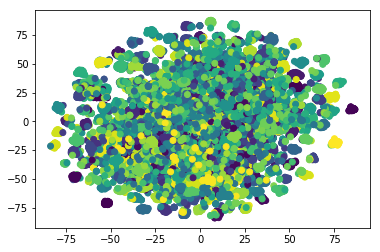

In [25]:
x, y = np.zeros((0,512)), []
embedding_paths = glob.glob(r'./datasets/XperFace/embeddings/*/*.npy')

for path in embedding_paths:
    x = np.vstack((x, np.load(path)))
    y.append(os.path.dirname(path).split(os.sep)[-1])
    
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

x_emb = TSNE(n_components=2).fit_transform(x)

plt.scatter(*x_emb.T, c=y)
plt.show()

## Face Tracking

In [ ]:
from cvt.models import SubspaceMethod

def format_input(X, y):
    X = [X[np.where(y==t)] for t in np.unique(y)]
    return X, np.unique(y)

in_paths = glob.glob(r'./datasets/XperFace/embeddings/*/*.npy')

In [ ]:
for query in queries:
    video_paths = glob.glob(r'./datasets/XperFace/videos/{0}/*.mp4'.format(query))
    
    # load reference face
    x, y = np.zeros((0,512)), []
    for path in in_paths:
        label = 1 if os.path.basename(os.path.dirname(path)) == query else 0
        x = np.vstack((x, np.load(path)))
        y.append(label)

    # use SM for face matching
    SM = SubspaceMethod(n_subdims=50)
    SM.fit(*format_input(x, y))
    
    for video_path in video_paths:
        vid = imageio.get_reader(video_path,  'ffmpeg') # fails sometimes ? 

        # get start time and end times
        
        prev_bbox = None
        # loop video frames
        for i, im in enumerate(vid):
            
            # Get list of all face bboxes in one frame
            image = Image.fromarray(im)
            bboxes, rois = utils.crop_faces(images=[image], return_values=['bboxes', 'rois']).values()
            embeddings = utils.embed_faces(images=rois, return_values='embeddings')

            if prev_bbox is None:
                if len(embeddings) == 1:
                    if SM.predict(embeddings):
                        print('found face!')
                else:
                    continue                
            else:                
                candidate_idx = np.where(SM.predict(embeddings)==1)
                candidate_rois = rois[candidate_idx]
                candidate_bboxes = bboxes[candidate_idx]
                print(candidate_bboxes)
            
            # TODO Add chunk to list
#             print('Mean of frame {0} is {1}, {2}, {3}'.format(i, im.mean(), type(im), im.shape))

            # TODO: face detection
            # Get list of all face bboxes in one frame
#             

            # TODO: Association with IoU and Embeddings


            # TODO Add chunk to list

        # TODO split vid to chunks


In [ ]:
SM.predict(x[0].reshape(1,-1))